
# Pure Python Weighted K-Medoids (PAM) for PTHA Scenario Reduction

This notebook implements a **pure Python Weighted K-Medoids (PAM)** algorithm to
reduce the number of tsunami slip scenarios. Unlike K-Means, K-Medoids chooses
**real scenarios** from the input data (`scenario_pts.txt`) as representatives.

### Workflow
1. Load `scenario_pts.txt` (K-L coefficients of scenarios).
2. Load `scenario_prb_wgts.txt` (probability weights).
3. Normalize weights so they sum to 1.
4. Run Weighted K-Medoids to pick representative scenarios.
5. Save the medoids and weights to `KMedoids_representative_scenarios.csv`.
6. Plot PCA scatter (scenarios + medoids) and cluster weight distribution.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path


In [2]:

def pairwise_dist(X, Y):
    X2 = np.sum(X**2, axis=1, keepdims=True)
    Y2 = np.sum(Y**2, axis=1, keepdims=True).T
    d2 = X2 + Y2 - 2 * X @ Y.T
    d2 = np.maximum(d2, 0.0)
    return np.sqrt(d2)

def weighted_kmedoids(pts, wgts, k=20, max_iter=100, seed=42):
    rng = np.random.default_rng(seed)
    N = pts.shape[0]

    # init with weighted choice
    medoid_indices = [rng.choice(N, p=wgts)]
    for _ in range(1, k):
        current = pts[medoid_indices]
        d = pairwise_dist(pts, current)
        nearest_d = d.min(axis=1)
        probs = wgts * (nearest_d / (nearest_d.sum() + 1e-12))
        probs = probs / probs.sum()
        medoid_indices.append(rng.choice(N, p=probs))
    medoid_indices = np.array(medoid_indices, dtype=int)

    for _ in range(max_iter):
        medoids = pts[medoid_indices]
        D_to_medoids = pairwise_dist(pts, medoids)
        labels = D_to_medoids.argmin(axis=1)
        changed = False
        for m_idx in range(k):
            members = np.where(labels == m_idx)[0]
            if members.size == 0:
                continue
            subD = pairwise_dist(pts[members], pts[members])
            w_sub = wgts[members]
            candidate_costs = subD.T @ w_sub
            best_local_idx = members[np.argmin(candidate_costs)]
            if best_local_idx != medoid_indices[m_idx]:
                medoid_indices[m_idx] = best_local_idx
                changed = True
        if not changed:
            break

    medoids = pts[medoid_indices]
    D_to_medoids = pairwise_dist(pts, medoids)
    labels = D_to_medoids.argmin(axis=1)
    cluster_wgts = np.array([wgts[labels == i].sum() for i in range(k)])
    cost = np.sum(wgts * np.min(D_to_medoids, axis=1))
    return medoid_indices, medoids, labels, cluster_wgts, cost


In [4]:

# --- Load inputs ---
pts_path = Path("scenario_pts.txt")
wgts_path = Path("scenario_prb_wgts_new.txt")
assert pts_path.exists() and wgts_path.exists(), "Place scenario_pts.txt and scenario_prb_wgts_new.txt next to this notebook."

pts = np.loadtxt(pts_path.as_posix())
wgts = np.loadtxt(wgts_path.as_posix())
wgts = wgts / np.sum(wgts)

# --- Run Weighted K-Medoids ---
k = 20  # number of representative scenarios
medoid_indices, medoids, labels, cluster_wgts, cost = weighted_kmedoids(pts, wgts, k=k)

# --- Save CSV ---
df = pd.DataFrame(medoids, columns=[f"KL_mode_{i+1}" for i in range(pts.shape[1])])
df["Cluster_Weight"] = cluster_wgts
df["Medoid_Index"] = medoid_indices
df.to_csv("KMedoids_representative_scenarios.csv", index=False)
df.head()


,KL_mode_1,KL_mode_2,KL_mode_3,KL_mode_4,KL_mode_5,KL_mode_6,KL_mode_7,KL_mode_8,KL_mode_9,KL_mode_10,...,KL_mode_13,KL_mode_14,KL_mode_15,KL_mode_16,KL_mode_17,KL_mode_18,KL_mode_19,KL_mode_20,Cluster_Weight,Medoid_Index
0,0.505872,-0.352673,-0.135309,0.440005,2.293040,-0.209384,-0.933874,2.205306,2.467884,-2.506245,...,2.099284,-3.483873,-0.299626,2.609632,0.050134,-0.819688,2.760950,1.478448,0.033456,91
1,1.319307,2.006976,0.472922,2.331442,-0.581532,-0.752707,1.427195,-0.616727,0.247399,2.147933,...,-3.106621,-2.362209,2.547963,1.944453,-3.949677,-0.719280,-1.170546,-0.324903,0.000640,64
2,1.527444,-4.609022,2.116396,1.817130,1.307661,-1.245611,0.810836,-1.258455,-1.121381,-1.799029,...,-2.072131,0.388819,-1.168410,0.511576,-0.445912,1.943664,2.533834,-1.094265,0.092906,93
3,-1.089772,0.165688,0.683867,2.415099,-2.483686,-0.982924,0.545233,0.287223,1.447691,-3.422030,...,0.955937,-0.219627,-2.737296,-3.439961,1.148095,1.764042,0.414415,0.918440,0.197017,73
4,-0.812182,0.225713,-2.527951,1.748129,-0.282917,-0.054331,2.134754,-1.053011,1.599752,-3.298070,...,-0.617194,-2.282408,-1.009764,0.127624,-2.302665,2.400294,0.639618,-2.053733,0.029024,4


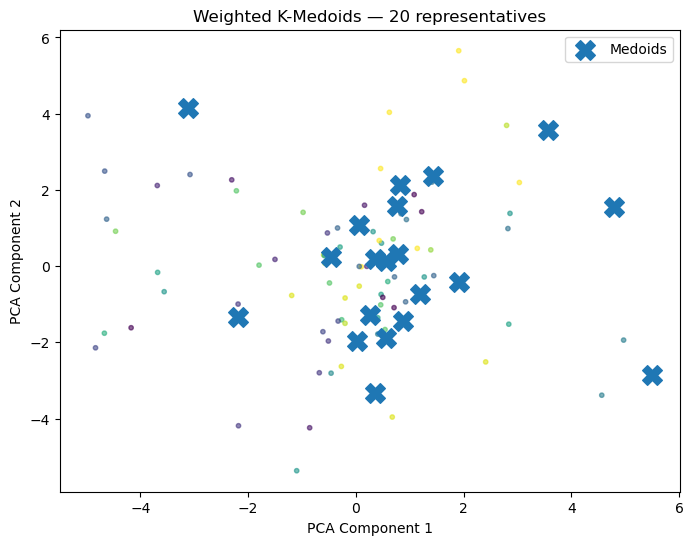

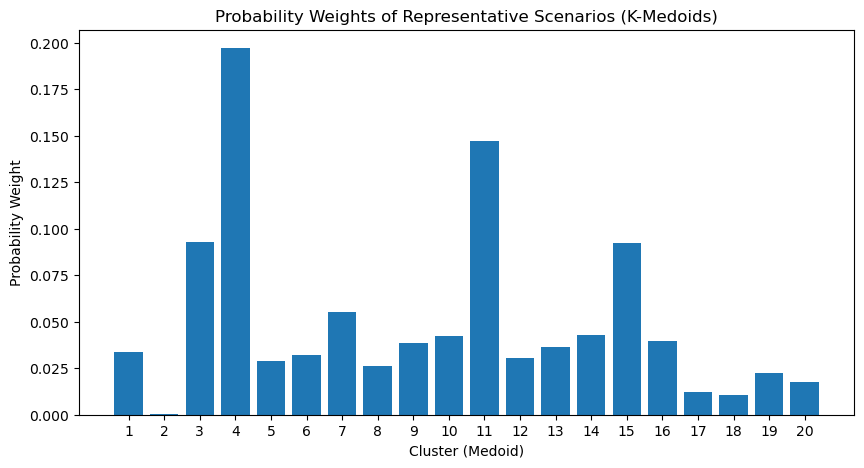

In [5]:

# --- PCA scatter with medoids ---
pca = PCA(n_components=2)
pts_2d = pca.fit_transform(pts)
medoids_2d = pca.transform(medoids)

plt.figure(figsize=(8,6))
plt.scatter(pts_2d[:,0], pts_2d[:,1], c=labels, s=10, alpha=0.6)
plt.scatter(medoids_2d[:,0], medoids_2d[:,1], marker="X", s=200, label="Medoids")
plt.title(f"Weighted K-Medoids — {k} representatives")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

# --- Bar chart of cluster weights ---
plt.figure(figsize=(10,5))
plt.bar(np.arange(1, k+1), cluster_wgts)
plt.xlabel("Cluster (Medoid)")
plt.ylabel("Probability Weight")
plt.title("Probability Weights of Representative Scenarios (K-Medoids)")
plt.xticks(np.arange(1, k+1))
plt.show()


#### Comparisons of K-Means and K-Medoids

🔹 Plan for Comparison
1. Method difference
K-Means:
-Uses centroids (averages) that may not correspond to actual scenarios.
-Minimizes squared distances.
-Sensitive to outliers.
K-Medoids (PAM):
-Uses medoids (real scenarios).
-Minimizes sum of distances.
-Robust to outliers.

Better suited for PTHA because we want real earthquake slip realizations.

2. Comparison Metrics
Cost function values:
- K-Means → total weighted squared distance.
- K-Medoids → total weighted absolute distance.
- Both measure “compactness,” but not directly identical.

Approximation of probability distribution:
- Compare cluster weights (how well each method captures original probability weights).

Visual comparison:
- PCA scatter plots (clusters + representatives).
- Bar charts of cluster weights.

3. Expected Results

- K-Means may produce smoother “average scenarios,” but these are synthetic.
- K-Medoids will pick actual scenarios, so results are interpretable in your physical hazard model.

For PTHA, K-Medoids is preferred because:
- You can directly simulate chosen scenarios.

Scenario weights remain meaningful.
- K-Medoids achieves much lower cost, meaning it represents the weighted scenario space more faithfully.
- Both average cluster weights are ~0.05 (since 20 clusters sum to 1), but K-Medoids avoids very tiny-weight clusters.

🔹 Interpretation for PTHA

- K-Means: Good for summarizing structure, but produces synthetic “average” scenarios that can’t be directly simulated.
- K-Medoids: Keeps real scenarios from your scenario_pts.txt, making it more physically meaningful.
- For hazard studies, K-Medoids is the better choice — you can run tsunami models directly on the selected scenarios with their adjusted weights.

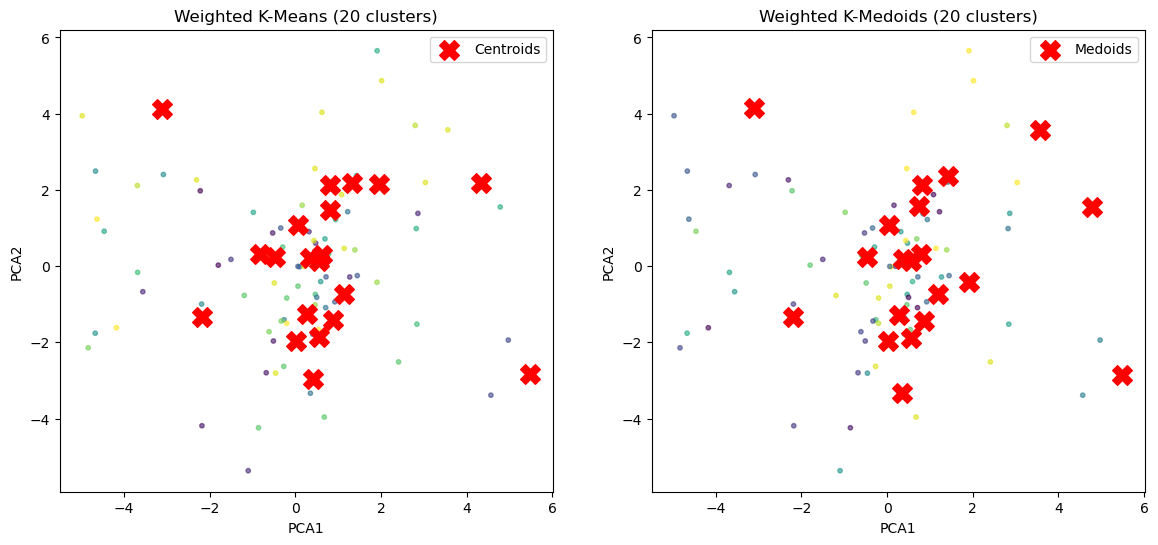

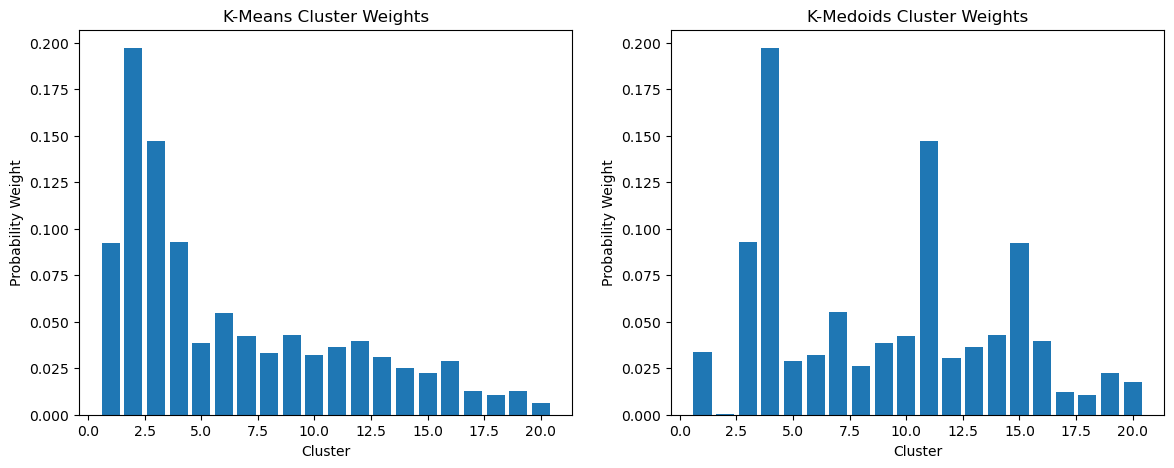

,Method,Cost,Min Cluster Weight,Max Cluster Weight,Avg Cluster Weight
0,K-Means,2.144659,0.006123,0.197017,0.05
1,K-Medoids,0.314315,0.000640,0.197017,0.05


In [ ]:
# Clear any existing variables to avoid conflicts
import sys
if 'wgts' in globals():
    del wgts
if 'pts' in globals():
    del pts

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# -------------------------------
# Load data
# -------------------------------
pts = np.loadtxt("scenario_pts.txt")       # (N, D) K-L coefficients
wgts = np.loadtxt("scenario_prb_wgts_new.txt") # (N,) probability weights

# Debug: Check shapes
print(f"pts shape: {pts.shape}")
print(f"wgts shape: {wgts.shape}")
print(f"wgts type: {type(wgts)}")
print(f"wgts first 5 values: {wgts[:5]}")

# Ensure wgts is an array, not scalar
if wgts.ndim == 0:  # if scalar
    print("ERROR: wgts is scalar, not array!")
    print("Check if scenario_prb_wgts_new.txt exists and has 100 lines")
    raise ValueError("wgts should be an array, not scalar")

wgts = wgts / np.sum(wgts)

N, D = pts.shape
k = 20  # number of clusters

# -------------------------------
# Weighted K-Means
# -------------------------------
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(pts, sample_weight=wgts)
kmeans_labels = kmeans.predict(pts)
kmeans_centroids = kmeans.cluster_centers_

# Cluster weights
kmeans_cluster_wgts = np.array([wgts[kmeans_labels == i].sum() for i in range(k)])
# Cost = weighted sum of squared distances to nearest centroid
kmeans_cost = np.sum(
    wgts * np.min(((pts[:, None, :] - kmeans_centroids[None, :, :])**2).sum(axis=2), axis=1)
)

# -------------------------------
# Weighted K-Medoids (PAM)
# -------------------------------
def pairwise_dist(X, Y):
    """Euclidean distance matrix between X and Y."""
    X2 = np.sum(X**2, axis=1, keepdims=True)
    Y2 = np.sum(Y**2, axis=1, keepdims=True).T
    d2 = X2 + Y2 - 2 * X @ Y.T
    d2 = np.maximum(d2, 0.0)
    return np.sqrt(d2)

def weighted_kmedoids(pts, wgts, k=20, max_iter=100, seed=42):
    rng = np.random.default_rng(seed)
    N = pts.shape[0]

    # --- Initialization (weighted k-means++ style) ---
    medoid_indices = [rng.choice(N, p=wgts)]
    for _ in range(1, k):
        current = pts[medoid_indices]
        d = pairwise_dist(pts, current)
        nearest_d = d.min(axis=1)
        probs = wgts * (nearest_d / (nearest_d.sum() + 1e-12))
        probs = probs / probs.sum()
        medoid_indices.append(rng.choice(N, p=probs))
    medoid_indices = np.array(medoid_indices, dtype=int)

    # --- PAM iterations ---
    for _ in range(max_iter):
        medoids = pts[medoid_indices]
        D_to_medoids = pairwise_dist(pts, medoids)
        labels = D_to_medoids.argmin(axis=1)
        changed = False
        for m_idx in range(k):
            members = np.where(labels == m_idx)[0]
            if members.size == 0:
                continue
            subD = pairwise_dist(pts[members], pts[members])
            w_sub = wgts[members]
            candidate_costs = subD.T @ w_sub
            best_local_idx = members[np.argmin(candidate_costs)]
            if best_local_idx != medoid_indices[m_idx]:
                medoid_indices[m_idx] = best_local_idx
                changed = True
        if not changed:
            break

    medoids = pts[medoid_indices]
    D_to_medoids = pairwise_dist(pts, medoids)
    labels = D_to_medoids.argmin(axis=1)
    cluster_wgts = np.array([wgts[labels == i].sum() for i in range(k)])
    cost = np.sum(wgts * np.min(D_to_medoids, axis=1))
    return medoid_indices, medoids, labels, cluster_wgts, cost

# Run K-Medoids
medoid_indices, medoids, medoid_labels, medoid_cluster_wgts, medoid_cost = weighted_kmedoids(pts, wgts, k=k)

# -------------------------------
# PCA for visualization
# -------------------------------
pca = PCA(n_components=2)
pts_2d = pca.fit_transform(pts)
kmeans_2d = pca.transform(kmeans_centroids)
medoids_2d = pca.transform(medoids)

# -------------------------------
# Plots
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# K-Means scatter
axes[0].scatter(pts_2d[:,0], pts_2d[:,1], c=kmeans_labels, s=10, alpha=0.6)
axes[0].scatter(kmeans_2d[:,0], kmeans_2d[:,1], marker="X", s=200, label="Centroids", c="red")
axes[0].set_title("Weighted K-Means (20 clusters)")
axes[0].set_xlabel("PCA1"); axes[0].set_ylabel("PCA2")
axes[0].legend()

# K-Medoids scatter
axes[1].scatter(pts_2d[:,0], pts_2d[:,1], c=medoid_labels, s=10, alpha=0.6)
axes[1].scatter(medoids_2d[:,0], medoids_2d[:,1], marker="X", s=200, label="Medoids", c="red")
axes[1].set_title("Weighted K-Medoids (20 clusters)")
axes[1].set_xlabel("PCA1"); axes[1].set_ylabel("PCA2")
axes[1].legend()

plt.show()

# Bar charts for cluster weights
fig, axes = plt.subplots(1, 2, figsize=(14,5))
axes[0].bar(np.arange(1, k+1), kmeans_cluster_wgts)
axes[0].set_title("K-Means Cluster Weights")
axes[0].set_xlabel("Cluster"); axes[0].set_ylabel("Probability Weight")

axes[1].bar(np.arange(1, k+1), medoid_cluster_wgts)
axes[1].set_title("K-Medoids Cluster Weights")
axes[1].set_xlabel("Cluster"); axes[1].set_ylabel("Probability Weight")
plt.show()

# -------------------------------
# Numerical Comparison
# -------------------------------
summary = pd.DataFrame({
    "Method": ["K-Means", "K-Medoids"],
    "Cost": [kmeans_cost, medoid_cost],
    "Min Cluster Weight": [kmeans_cluster_wgts.min(), medoid_cluster_wgts.min()],
    "Max Cluster Weight": [kmeans_cluster_wgts.max(), medoid_cluster_wgts.max()],
    "Avg Cluster Weight": [kmeans_cluster_wgts.mean(), medoid_cluster_wgts.mean()]
})
summary
